In [1]:
import pandas as pd 
import numpy as np
import random
import sys
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pickle
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

In [3]:
#read dataframe
df = pd.read_csv("/content/drive/MyDrive/stock_rating/final_df.csv")

In [4]:
df

,Unnamed: 0,ticker,date,close,volume,calendardate,accoci,assets,assetsavg,assetsc,assetsnc,assetturnover,bvps,capex,cashneq,cor,consolinc,currentratio,de,debt,debtc,debtnc,deferredrev,depamor,deposits,dps,ebit,ebitda,ebitdamargin,ebt,eps,epsdil,equity,equityavg,fcf,fcfps,gp,grossmargin,intangibles,intexp,...,volume_semi_annual_avg,volume_annual_avg,volume_two_year_avg,volume_three_year_avg,price_change_weekly_avg,price_change_month_avg,price_change_quarter_avg,price_change_semi_annual_avg,price_change_annual_avg,price_change_two_year_avg,price_change_three_year_avg,volume_change_weekly_avg,volume_change_month_avg,volume_change_quarter_avg,volume_change_semi_annual_avg,volume_change_annual_avg,volume_change_two_year_avg,volume_change_three_year_avg,divyield,marketcap,ev,evebit,pb,pe,peg1,peg2,peg3,rating_cnt_strong_buys,rating_cnt_mod_buys,rating_cnt_holds,rating_cnt_mod_sells,rating_cnt_strong_sells,rating_mean_recom,rating_cnt_with,rating_cnt_without,rating_change,dcf,actualEarningResult,estimatedEarning,earnings_surprise
0,0,A,2019-02-20,78.56,2076523.0,2018-12-31,-381000000.0,8.952000e+09,8.656500e+09,3.712000e+09,5.240000e+09,0.576,15.836,-155000000.0,2.057000e+09,2.266000e+09,1.140000e+09,3.390,0.778,1.798000e+09,0.0,1.798000e+09,346000000.0,213000000.0,0.0,0.611,1.034000e+09,1.247000e+09,0.250,961000000.0,3.56,3.53,5.036000e+09,4.695000e+09,930000000.0,2.925,2.721000e+09,0.546,3.699000e+09,73000000.0,...,2.387455e+06,2.527169e+06,2.527169e+06,2.527169e+06,0.003886,0.004253,0.003269,0.001696,0.000483,0.000483,0.000483,0.056122,0.084276,0.077535,0.074331,0.076015,0.076015,0.076015,0.007777,2.494405e+10,2.468505e+10,19.795547,4.953147,22.067416,4.653673,17.409971,7.344236,8.0,2.0,0.0,0.0,0.0,1.1,10.0,0.0,0,84.948199,0.76,0.73,0.03
1,1,A,2019-02-21,77.89,3570828.0,2018-12-31,-381000000.0,8.952000e+09,8.656500e+09,3.712000e+09,5.240000e+09,0.576,15.836,-155000000.0,2.057000e+09,2.266000e+09,1.140000e+09,3.390,0.778,1.798000e+09,0.0,1.798000e+09,346000000.0,213000000.0,0.0,0.611,1.034000e+09,1.247000e+09,0.250,961000000.0,3.56,3.53,5.036000e+09,4.695000e+09,930000000.0,2.925,2.721000e+09,0.546,3.699000e+09,73000000.0,...,2.402938e+06,2.529871e+06,2.529871e+06,2.529871e+06,0.001713,0.004250,0.003068,0.001652,0.000452,0.000452,0.000452,0.265471,0.105623,0.092601,0.082730,0.080483,0.080483,0.080483,0.007844,2.473131e+10,2.447231e+10,19.624949,4.910904,21.879213,4.613984,17.261490,7.281601,8.0,2.0,0.0,0.0,0.0,1.1,10.0,0.0,0,84.278199,0.76,0.73,0.03
2,2,A,2019-02-22,78.42,2797669.0,2018-12-31,-381000000.0,8.952000e+09,8.656500e+09,3.712000e+09,5.240000e+09,0.576,15.836,-155000000.0,2.057000e+09,2.266000e+09,1.140000e+09,3.390,0.778,1.798000e+09,0.0,1.798000e+09,346000000.0,213000000.0,0.0,0.611,1.034000e+09,1.247000e+09,0.250,961000000.0,3.56,3.53,5.036000e+09,4.695000e+09,930000000.0,2.925,2.721000e+09,0.546,3.699000e+09,73000000.0,...,2.401469e+06,2.530730e+06,2.530730e+06,2.530730e+06,0.003670,0.004354,0.003757,0.001649,0.000528,0.000528,0.000528,0.187034,0.093438,0.086873,0.074334,0.080047,0.080047,0.080047,0.007791,2.489959e+10,2.464059e+10,19.759899,4.944320,22.028090,4.645380,17.378945,7.331148,9.0,1.0,0.0,0.0,0.0,1.1,10.0,0.0,1,84.808199,0.76,0.73,0.03
3,3,A,2019-02-25,79.34,1878041.0,2018-12-31,-381000000.0,8.952000e+09,8.656500e+09,3.712000e+09,5.240000e+09,0.576,15.836,-155000000.0,2.057000e+09,2.266000e+09,1.140000e+09,3.390,0.778,1.798000e+09,0.0,1.798000e+09,346000000.0,213000000.0,0.0,0.611,1.034000e+09,1.247000e+09,0.250,961000000.0,3.56,3.53,5.036000e+09,4.695000e+09,930000000.0,2.925,2.721000e+09,0.546,3.699000e+09,73000000.0,...,2.396012e+06,2.530265e+06,2.530265e+06,2.530265e+06,0.002692,0.004560,0.002698,0.001654,0.000565,0.000565,0.000565,0.084022,0.090343,0.059205,0.072836,0.079643,0.079643,0.079643,0.007701,2.519171e+10,2.493271e+10,19.994153,5.002325,22.286517,4.699878,17.582830,7.417155,9.0,1.0,0.0,0.0,0.0,1.1,10.0,0.0,0,85.728199,0.76,0.73,0.03
4,4,A,2019-02-26,78.55,1992595.0,2018-12-31,-381000000.0,8.95

In [5]:
#drop unneeded fields/columns
df.drop([
 'Unnamed: 0',
 'date',
 'calendardate',
 'name',
 'rating_cnt_strong_buys',
 'rating_cnt_mod_buys',
 'rating_cnt_holds',
 'rating_cnt_mod_sells',
 'rating_cnt_strong_sells',
 'rating_cnt_with',
 'rating_cnt_without',
 'rating_change',
 'quart',
 'year'
 ], axis=1, inplace=True)

In [6]:
#select categorical features
one_hot_features = ['exchange', 'sector', 'industry']

In [7]:
#one hot encode categorical features
for feature in one_hot_features:
    cat_X = df.loc[:, [feature]]
    ohe = OneHotEncoder(drop='first', sparse=False)
    ohe.fit(cat_X)
    ohe_X = ohe.transform(cat_X)
    columns = ohe.get_feature_names([feature])
    ohe_X_df = pd.DataFrame(ohe_X, columns=columns, index=cat_X.index)
    df = df.join(ohe_X_df)

In [10]:
#train/val/test split so that validate/testing sets contain seperate unseen tickers
tickers = list(df.ticker.unique())
test_tickers = random.sample(tickers, int(df.ticker.nunique() * .2))

In [11]:
df_train1 = df[~df.ticker.isin(test_tickers)]

In [12]:
df_test = df[df.ticker.isin(test_tickers)]

In [13]:
train_tickers = list(df_train1.ticker.unique())
validate_tickers = random.sample(tickers, int(df_train1.ticker.nunique() * .4))

In [14]:
df_train = df_train1[~df_train1.isin(validate_tickers)]

In [15]:
df_validate = df_train1[df_train1.ticker.isin(validate_tickers)]

In [16]:
#view splits
print(len(df_train))
print(len(df_validate))
print(len(df_test))

864724
275323
216869


In [17]:
#drop uneeded columns
df_train.drop([
 'ticker',
 'exchange',
 'sector',
 'industry'
 ], axis=1, inplace=True)

In [18]:
df_test.drop([
 'ticker',
 'exchange',
 'sector',
 'industry'
 ], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
df_validate.drop([
 'ticker',
 'exchange',
 'sector',
 'industry'
 ], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
x_train = df_train.copy()
del x_train["rating_mean_recom"]
y_train = df_train["rating_mean_recom"]

In [21]:
x_validate = df_validate.copy()
del x_validate["rating_mean_recom"]
y_validate = df_validate["rating_mean_recom"]

In [22]:
x_test = df_test.copy()
del x_test["rating_mean_recom"]
y_test = df_test["rating_mean_recom"]

In [23]:
ss = StandardScaler()

ss.fit(x_train)

x_train_scaled = ss.transform(x_train)

x_validate_scaled = ss.transform(x_validate)

x_test_scaled = ss.transform(x_test)

In [24]:
x_train.shape

(864724, 324)

In [25]:
# instantiate model
model = keras.Sequential()

# add first layer to model. Defines the size of the input layer.

model.add(layers.Dropout(0.4, input_shape=(324,)))

#add other layers, including dropouts
model.add(layers.Dense(1000,
                       activation='relu'))

model.add(layers.Dropout(0.2))

model.add(layers.Dense(500,
                       activation='relu'))

model.add(layers.Dropout(0.2))

model.add(layers.Dense(100,
                       activation='relu'))

model.add(layers.Dropout(0.2))

model.add(layers.Dense(50,
                       activation='relu'))

model.add(layers.Dropout(0.2))

model.add(layers.Dense(250,
                       activation='relu'))

model.add(layers.Dropout(0.2))

model.add(layers.Dense(75,
                       activation='relu'))

model.add(layers.Dropout(0.2))

model.add(layers.Dense(10,
                       activation='relu'))

#add output layer
model.add(layers.Dense(1))

#summmarize model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 324)               0         
_________________________________________________________________
dense (Dense)                (None, 1000)              325000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               50100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0

In [26]:
#select SGD as optimizer and loss function as MAE (also tracking MSE)
model.compile(optimizer='SGD', 
             loss='mae',       
             metrics=['mse'],  
             )

In [28]:
#fit model
history = model.fit(x_train_scaled, y_train,       
        batch_size=1000,
        epochs=50,             
        validation_data= (x_validate_scaled, y_validate))

Epoch 1/50
865/865 [==============================] - 6s 5ms/step - loss: 0.9936 - mse: 1.6433 - val_loss: 0.7424 - val_mse: 0.8217
Epoch 2/50
865/865 [==============================] - 4s 4ms/step - loss: 0.7771 - mse: 0.8980 - val_loss: 0.7131 - val_mse: 0.7872
Epoch 3/50
865/865 [==============================] - 4s 4ms/step - loss: 0.7590 - mse: 0.8777 - val_loss: 0.7018 - val_mse: 0.7802
Epoch 4/50
865/865 [==============================] - 4s 4ms/step - loss: 0.7494 - mse: 0.8691 - val_loss: 0.6967 - val_mse: 0.7800
Epoch 5/50
865/865 [==============================] - 4s 4ms/step - loss: 0.7444 - mse: 0.8659 - val_loss: 0.6936 - val_mse: 0.7769
Epoch 6/50
865/865 [==============================] - 4s 4ms/step - loss: 0.7401 - mse: 0.8597 - val_loss: 0.6899 - val_mse: 0.7723
Epoch 7/50
865/865 [==============================] - 4s 4ms/step - loss: 0.7365 - mse: 0.8566 - val_loss: 0.6864 - val_mse: 0.7704
Epoch 8/50
865/865 [==============================] - 4s 4ms/step - loss: 0.

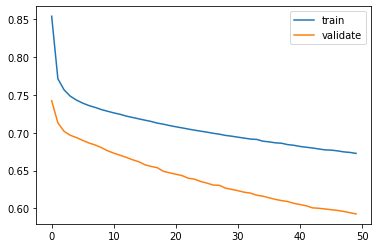

In [29]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validate')
plt.legend()
plt.show();

In [30]:
mae, mse = model.evaluate(x_train_scaled, y_train, verbose=False)

print(f'''MSE: {mse:.4f} \nMAE: {mae:.4f}''')

MSE: 0.7062 
MAE: 0.6034


In [31]:
mae, mse = model.evaluate(x_validate_scaled, y_validate, verbose=False)

print(f'''MSE: {mse:.4f} \nMAE: {mae:.4f}''')

MSE: 0.6771 
MAE: 0.5925


In [32]:
mae, mse = model.evaluate(x_test_scaled, y_test, verbose=False)

print(f'''MSE: {mse:.4f} \nMAE: {mae:.4f}''')

MSE: 0.8845 
MAE: 0.7294


In [34]:
model.save('/content/drive/MyDrive/stock_rating/ann_model_final')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/stock_rating/ann_model_final/assets
